In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from pathlib import Path

import os
os.chdir('../')

from src.features.comparison_utils import (
    get_country_statistics,
    compare_two_countries,
    get_similar_pairs,
    SHORTCUTS,
)

from src.visualization.plot_utils import (
    plot_total_vs_week,
    get_comparison_plots,
    plot_vaccination_for_country,
    plot_lambda_for_country,
    plot_indicator_kde,
    plot_effect_types,
)

from src.features.covid_spread_utils import get_max_covid_corr
import notebooks.config as experim_cfg

%matplotlib inline

# Read the data

If you don't have csv in your repository you may consider running *src/data/download_covid_data.py*

In [2]:
data_path = Path('data', 'external', 'owid-covid-data.csv')
covid_data = pd.read_csv(data_path, index_col=0)
covid_data = covid_data[~covid_data.iso_code.str.contains('OWID')]

In [3]:
covid_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [4]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

# Mortality vs vaccines

Let's filter data with mortality and vaccinations not null at the same time.

In [5]:
country_corr=covid_data.groupby('iso_code')[
    [experim_cfg.VACCINATION_INDICATOR, experim_cfg.MORTALITY_INDICATOR]
].corr().unstack().iloc[:,1].reset_index()

country_corr.columns=['iso_code','correlation']

not_na_corr_countries = country_corr[
    ~country_corr.correlation.isna()
]

In [6]:
not_na_corr_countries

iso_code  correlation
0        ABW     0.205695
4        ALB    -0.367766
8        ARM     1.000000
9        ATG    -0.943422
10       AUS     0.613605
..       ...          ...
212      UKR     0.267657
213      URY    -0.114229
214      USA    -0.357439
215      UZB    -0.077198
226      ZAF    -0.608905

[86 rows x 2 columns]

In [7]:
data_count = covid_data[
    covid_data[experim_cfg.MORTALITY_INDICATOR].notna() &
    covid_data[experim_cfg.MORTALITY_INDICATOR].gt(0)
].groupby('iso_code')['continent'].count()
filtration_threshold = np.quantile(data_count, 0.3)
filtrated_isocodes = data_count[data_count > filtration_threshold].index

In [8]:
covid_data[
    covid_data[experim_cfg.MORTALITY_INDICATOR].notna() &
    covid_data[experim_cfg.MORTALITY_INDICATOR].gt(0)
].groupby('iso_code')['continent'].count()

iso_code
ABW     17
ALB     25
AND      8
ARG      7
ARM     27
      ... 
UKR     20
URY     14
USA    121
UZB     18
ZAF    118
Name: continent, Length: 113, dtype: int64

In [9]:
mort_vac_not_na = covid_data[
    covid_data[[experim_cfg.VACCINATION_INDICATOR, experim_cfg.MORTALITY_INDICATOR]].notnull().all(axis=1) &
    covid_data.iso_code.isin(not_na_corr_countries.iso_code) &
    covid_data.iso_code.isin(filtrated_isocodes) &
    covid_data[experim_cfg.MORTALITY_INDICATOR].gt(0)
].copy()

## Correlation for all data 

In [10]:
vac_mort_coef = np.corrcoef(
    mort_vac_not_na[experim_cfg.VACCINATION_INDICATOR],
    mort_vac_not_na[experim_cfg.MORTALITY_INDICATOR],
)[0][1]
print(vac_mort_coef)

-0.2948524359661915


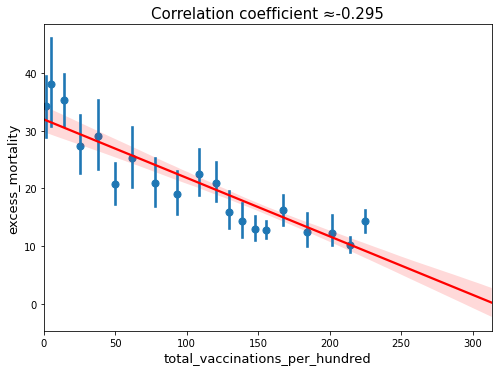

In [11]:
plt.figure(figsize=(7,5))
sns.regplot(
    x=mort_vac_not_na[experim_cfg.VACCINATION_INDICATOR],
    y=mort_vac_not_na[experim_cfg.MORTALITY_INDICATOR],
    x_bins=20,
    line_kws={'color':'red'},
)
plt.tight_layout()
plt.xlabel(experim_cfg.VACCINATION_INDICATOR, size=13)
plt.ylabel(experim_cfg.MORTALITY_INDICATOR, size=13)
plt.title(f'Correlation coefficient ≈{vac_mort_coef:.3f}', size=15)
plt.savefig(
    experim_cfg.get_pic_save_path(plot_type='corr'),
    transparent=True,
    dpi=500,
    bbox_inches='tight',
)

In [12]:
mort_vac_not_na['new_deaths_smoothed_per_million'].eq(0).any()

True

<Figure size 504x504 with 0 Axes>

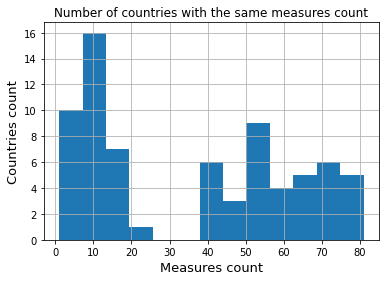

In [13]:
plt.figure(figsize=(7,7))
mort_vac_not_na.groupby('iso_code')['continent'].count().reset_index().hist(bins=13)


plt.xlabel('Measures count', size=13)
plt.ylabel('Countries count', size=13)
plt.title('Number of countries with the same measures count', size=12)
# plt.tight_layout()
plt.savefig(
    experim_cfg.get_pic_save_path(plot_type='measures_count'),
    transparent=True,
    dpi=500,
    bbox_inches='tight',
)

In [14]:
mort_vac_not_na.groupby(['iso_code'])[['continent']].count()

continent
iso_code           
ABW               6
ALB               8
ARM               2
AUS              57
AUT              73
...             ...
THA              13
UKR              11
USA              80
UZB               2
ZAF              53

[72 rows x 1 columns]

Some counties provide more frequent data than other, therefore counting the mean correlation may be incorrect due to different weghts for different countries. So, the value calculated above is correct only if correlation for vaccinations vs excess deaths does not depend on other factors.

## Correlation per country

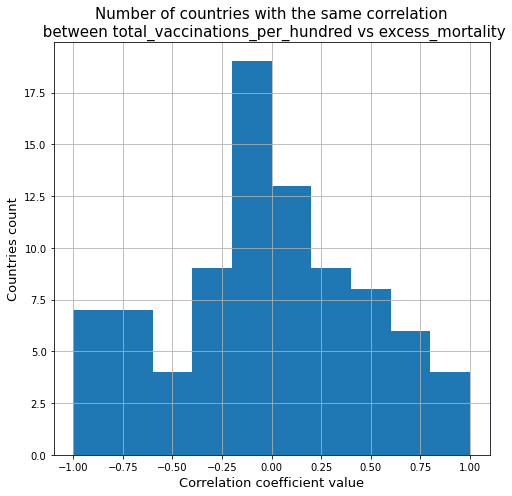

In [15]:
plt.figure(figsize=(7,7))
not_na_corr_countries.correlation.hist(bins=10)


plt.xlabel('Correlation coefficient value', size=13)
plt.ylabel('Countries count', size=13)
plt.title(
    f'Number of countries with the same correlation\n between {experim_cfg.VACCINATION_INDICATOR} vs {experim_cfg.MORTALITY_INDICATOR}',
    size=15
)
plt.tight_layout()
plt.savefig(
    experim_cfg.get_pic_save_path(plot_type='corr_hist'),
    transparent=True,
    dpi=500,
    bbox_inches='tight',
)

In [16]:
# Mean correlation for country correlation is greater than 0
not_na_corr_countries.correlation.mean()

-0.03254768708273783

In [17]:
print(f'Subset countries count = {mort_vac_not_na.iso_code.unique().shape[0]}')
print(f'World countries count = {covid_data.iso_code.unique().shape[0]}')

Subset countries count = 72
World countries count = 229


One may notice that such subsetting leads to decrease in the number of countries in the subsample. Hence, such subsetting of the data with only existing info may be incorrect due to selection bias. We need to make sure that the distributions of the countries main well-being indicators remained unchanged.

### Well being indicators in mortality-vaccination subset

In [18]:
well_being_indicators = [
    'aged_70_older',
    'aged_65_older',
    'gdp_per_capita',
    'extreme_poverty',
    'hospital_beds_per_thousand',
    'human_development_index',
    'median_age',
    'population_density',
]

for indicator in well_being_indicators:
    assert (covid_data.groupby(['iso_code'])[indicator].nunique() < 2).all(), indicator
# There is only one unique value for each well-being indicators in each country

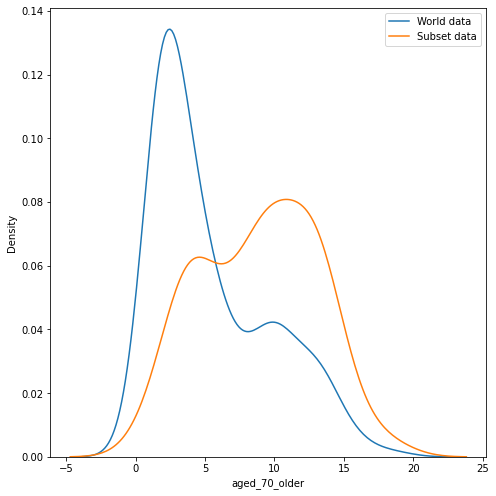

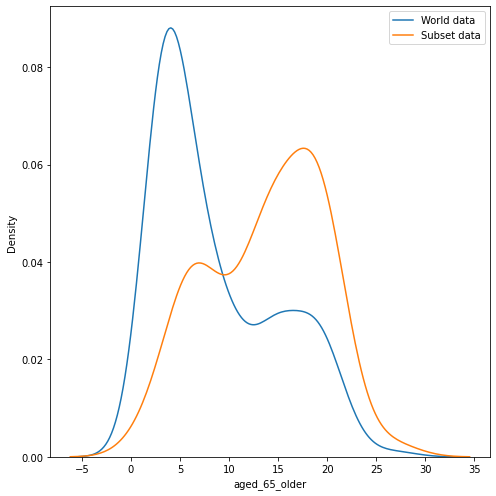

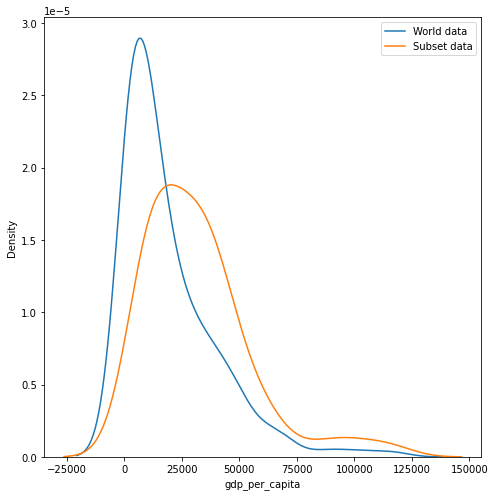

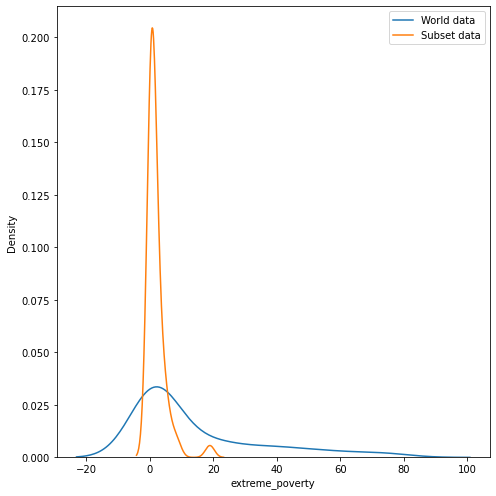

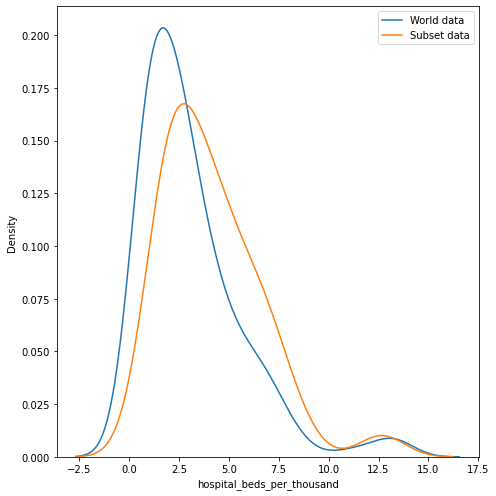

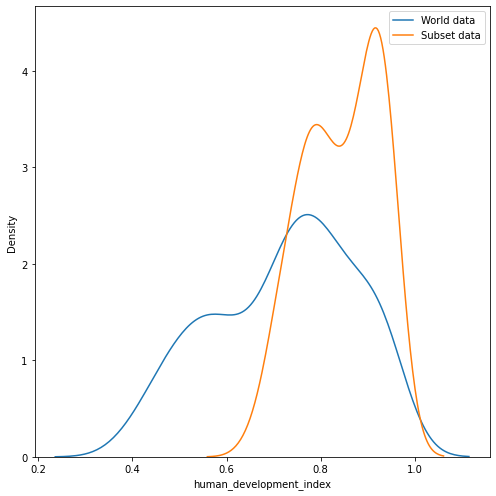

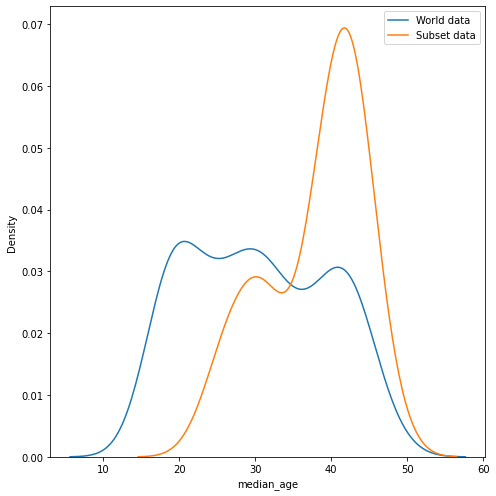

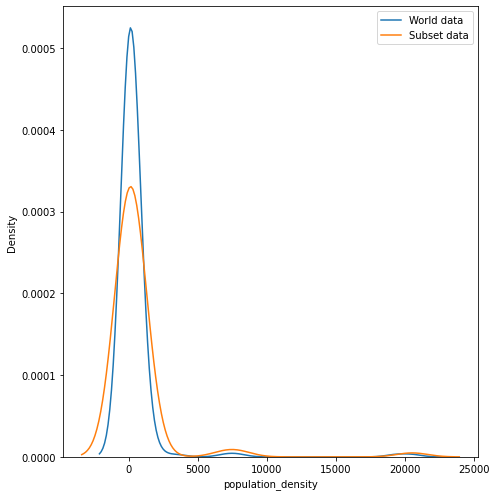

In [19]:
for indicator in well_being_indicators:
    plot_indicator_kde(
        covid_df=covid_data,
        indicator=indicator,
        iso_codes_for_subset=mort_vac_not_na.iso_code.unique(),
        save_plot=True,
    )

In [20]:
unique_countries = mort_vac_not_na.groupby(['iso_code'], as_index=False).first()
unique_countries = unique_countries[well_being_indicators + ['iso_code']]

In [21]:
unique_countries['corr_vac_exc_deaths'] = unique_countries['iso_code'].map(
    not_na_corr_countries.set_index('iso_code', drop=True,).correlation
)

In [22]:
# Drop countries with less than 5 data points
reports_per_country = mort_vac_not_na.groupby(['iso_code']).excess_mortality.count()
countries_gt_5_reports = reports_per_country[reports_per_country > 5].index

unique_countries = unique_countries[unique_countries.iso_code.isin(countries_gt_5_reports)]

Text(0.5, 1.0, 'Number of countries with the same correlation\n for vaccinations vs excess deaths')

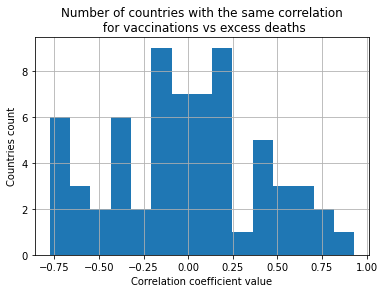

In [23]:
plt.figure()
unique_countries.corr_vac_exc_deaths.hist(bins=15)
plt.xlabel('Correlation coefficient value')
plt.ylabel('Countries count')
plt.title('Number of countries with the same correlation\n for vaccinations vs excess deaths')

In [24]:
corr_bins = [-1, -0.5, 0, 0.5, 1]
corr_labels = ['strong_neg', 'neg', 'pos', 'strong_pos']
unique_countries['corr_quadrant'] = pd.cut(
    unique_countries['corr_vac_exc_deaths'],
    bins=corr_bins,
    labels=corr_labels,
)

In [25]:
unique_countries[
    well_being_indicators +['corr_quadrant']
].groupby(['corr_quadrant']).agg(['mean']).T

corr_quadrant                      strong_neg           neg           pos  \
aged_70_older              mean      4.346667      9.266200     11.105130   
aged_65_older              mean      7.199111     14.071920     16.825958   
gdp_per_capita             mean  25562.397778  22970.489875  37527.198708   
extreme_poverty            mean      4.671429      2.183333      0.741176   
hospital_beds_per_thousand mean      2.527778      4.037320      5.196727   
human_development_index    mean      0.774000      0.825360      0.887043   
median_age                 mean     30.933333     37.948000     41.291667   
population_density         mean     69.740889    124.197480    499.560042   

corr_quadrant                      strong_pos  
aged_70_older              mean      9.354000  
aged_65_older              mean     15.046625  
gdp_per_capita             mean  52775.127250  
extreme_poverty            mean      1.275000  
hospital_beds_per_thousand mean      4.371429  
human_development_index    mean      0.919429  
median_age                 mean     40.250000  
population_density         mean   3638.687750

In [26]:
unique_countries

aged_70_older  aged_65_older  gdp_per_capita  extreme_poverty  \
0           7.452         13.085       35973.781              NaN   
1           8.643         13.188       11803.431              1.1   
3          10.129         15.504       44648.710              0.5   
4          13.748         19.202       45436.686              0.7   
5           3.871          6.018       15847.419              NaN   
..            ...            ...             ...              ...   
66         13.433         19.985       46949.283              0.5   
67          6.890         11.373       16277.671              0.1   
68         11.133         16.462        7894.393              0.1   
69          9.732         15.413       54225.446              1.2   
71          3.053          5.344       12294.876             18.9   

    hospital_beds_per_thousand  human_development_index  median_age  \
0                          NaN                      NaN        41.2   
1                         2.89                    0.795        38.0   
3                         3.84                    0.944        37.9   
4                         7.37                    0.922        44.4   
5                         4.70                    0.756        32.4   
..                         ...                      ...         ...   
66                        2.22                    0.945        41.0   
67                        2.10                    0.777        40.1   
68                        8.80                    0.779        41.4   
69                        2.77                    0.926        38.3   
71                        2.32                    0.709        27.3   

    population_density iso_code  corr_vac_exc_deaths corr_quadrant  
0              584.800      ABW             0.205695           pos  
1              104.871      ALB            -0.367766           neg  
3                3.202      AUS             0.613605    strong_pos  
4              106.749      AUT             0.246367           pos  
5              119.309      AZE            -0.143804           neg  
..                 ...      ...                  ...           ...  
66              24.718      SWE             0.116996           pos  
67             135.132      THA             0.466645           pos  
68              77.390      UKR             0.267657           pos  
69              35.608      USA            -0.357439           neg  
71              46.754      ZAF            -0.608905    strong_neg  

[66 rows x 11 columns]

In [27]:
unique_countries_stats_path = Path(
    'data',
    'interim',
    f'unique_countries_({experim_cfg.MORTALITY_INDICATOR}).csv',
)
unique_countries.to_csv(unique_countries_stats_path, index=False)